In [1]:
import os
from pyspark.storagelevel import StorageLevel


os.environ["PYSPARK_SUBMIT_ARGS"] = (
    "--packages graphframes:graphframes:0.8.1-spark3.0-s_2.12 pyspark-shell"
)

import pyspark
from pyspark.sql import SparkSession
from App.utils import *
from graphframes import *

hdfs_host = "hdfs://localhost:9000"
hdfs_root_path = "/SafeEntry_Analytics/"

conf = pyspark.SparkConf().setAppName("Explore Entry Record").setMaster("local[*]")
sc = pyspark.SparkContext.getOrCreate(conf=conf)
spark = SparkSession(sc)

resident_file_dest = "resident.parquet"
place_file_dest = "place.parquet"
safe_entry_file_dest = "entry_record.parquet"
contact_graph_edge_file_dest = "contact_graph_edge.parquet"
contact_graph_vertex_file_dest = "contact_graph_vertex.parquet"

communities_file_dest = "communities.parquet"

#### Step 1: Retrieve Graph Data

In [2]:
e = read_parquet_file(spark, hdfs_host + hdfs_root_path + contact_graph_edge_file_dest)
v = read_parquet_file(spark, hdfs_host + hdfs_root_path + contact_graph_vertex_file_dest)
g = GraphFrame(v, e)
g.cache()
g.edges.show()
g.vertices.show()


+--------+--------+
|     src|     dst|
+--------+--------+
|F001280F|F001567H|
|F001567H|F001280F|
|S001959K|S001067Q|
|S001067Q|S001959K|
|F000583F|S001959K|
|S001959K|F000583F|
|S001629B|S000637Y|
|S000637Y|S001629B|
|S001138U|F000260X|
|F000260X|S001138U|
|S001138U|F001805K|
|F001805K|S001138U|
|F000547Y|F000110F|
|F000110F|F000547Y|
|F000468M|F000322Y|
|F000322Y|F000468M|
|F000468M|F001910O|
|F001910O|F000468M|
|F000468M|F000569X|
|F000569X|F000468M|
+--------+--------+
only showing top 20 rows

+-----------+------------------+--------+------------+--------------------+
|resident_id|     resident_name|      id|phone_number|      last_update_dt|
+-----------+------------------+--------+------------+--------------------+
|    rid_106| resident_name_106|F000106C|    90000106|2021-04-13 23:22:...|
|    rid_489| resident_name_489|F000489V|    80000489|2021-04-13 23:22:...|
|    rid_670| resident_name_670|F000670X|    90000670|2021-04-13 23:22:...|
|    rid_749| resident_name_749|F00074

#### Step 2: visualize in NetworkX

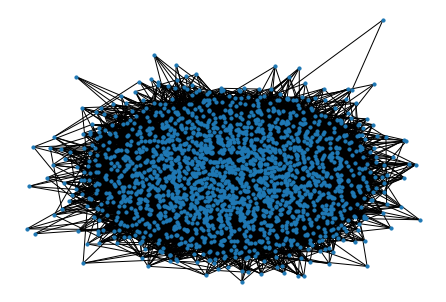

In [3]:
g_pdf = g.edges.select("*").toPandas()

import networkx as nx
import matplotlib.pyplot as plt
g_nx = nx.from_pandas_edgelist(g_pdf, source='src', target='dst')
nx.draw(g_nx,node_size = 10)
plt.show()

#### Step 3.1: Find Close Node

In [4]:
from pyspark.sql.functions import explode

confirmed_cases = ['F001576U']

shortest_path_df = g.shortestPaths(landmarks=confirmed_cases)
shortest_path_df.select("id", "distances").orderBy('id').show(20,False)

shortest_path_df=shortest_path_df.select("id", explode("distances"))

print(f"============close contact as below============")
shortest_path_df.filter(shortest_path_df.value == 1).show()

+--------+---------------+
|id      |distances      |
+--------+---------------+
|F000003Q|[F001576U -> 4]|
|F000004E|[F001576U -> 3]|
|F000006D|[F001576U -> 2]|
|F000007E|[F001576U -> 3]|
|F000010H|[F001576U -> 4]|
|F000012O|[F001576U -> 2]|
|F000015T|[F001576U -> 3]|
|F000017L|[F001576U -> 3]|
|F000019Q|[F001576U -> 3]|
|F000020N|[F001576U -> 3]|
|F000023U|[F001576U -> 2]|
|F000024G|[F001576U -> 2]|
|F000025W|[F001576U -> 3]|
|F000026E|[F001576U -> 3]|
|F000027T|[F001576U -> 3]|
|F000029J|[F001576U -> 3]|
|F000030M|[F001576U -> 2]|
|F000031I|[F001576U -> 3]|
|F000033K|[F001576U -> 3]|
|F000035B|[F001576U -> 3]|
+--------+---------------+
only showing top 20 rows

============close contact as below============
+--------+--------+-----+
|      id|     key|value|
+--------+--------+-----+
|S000892M|F001576U|    1|
|S000717Q|F001576U|    1|
|S000780W|F001576U|    1|
|F001178Y|F001576U|    1|
|S001140L|F001576U|    1|
|S000912I|F001576U|    1|
|F001068L|F001576U|    1|
|F001766I|F001576U|

#### Step 3.2: Community Detection
##### Build model, can not use SCC and CC

In [5]:
communities_df = g.labelPropagation(maxIter=10)

from pyspark.sql import functions as func
communities_df.sort("label").groupby("label").agg(func.collect_list("id")).show()

communities_df.orderBy("label").show()

communities_hdfs_path = hdfs_host + hdfs_root_path + communities_file_dest
communities_df.write.mode("Overwrite").parquet(communities_hdfs_path)

+------------+--------------------+
|       label|    collect_list(id)|
+------------+--------------------+
|343597383683|[F000673V, F00107...|
+------------+--------------------+

+-----------+------------------+--------+------------+--------------------+------------+
|resident_id|     resident_name|      id|phone_number|      last_update_dt|       label|
+-----------+------------------+--------+------------+--------------------+------------+
|    rid_354| resident_name_354|F000354X|    80000354|2021-04-13 23:22:...|343597383683|
|   rid_1261|resident_name_1261|F001261C|    90001261|2021-04-13 23:22:...|343597383683|
|    rid_930| resident_name_930|S000930J|    80000930|2021-04-13 23:22:...|343597383683|
|   rid_1259|resident_name_1259|S001259E|    90001259|2021-04-13 23:22:...|343597383683|
|    rid_632| resident_name_632|F000632W|    80000632|2021-04-13 23:22:...|343597383683|
|   rid_1911|resident_name_1911|S001911A|    80001911|2021-04-13 23:22:...|343597383683|
|    rid_128| resi

##### Find Cluster for resident

In [6]:
confirmed_case = 'F000006D'
label = communities_df.filter("id = '" + confirmed_case + "'" ).collect()[0]['label']

print('============Resident in the same cluster============')
communities_df.filter("label = '"+ str(label) +"'").show()

============Resident in the same cluster============
+-----------+------------------+--------+------------+--------------------+------------+
|resident_id|     resident_name|      id|phone_number|      last_update_dt|       label|
+-----------+------------------+--------+------------+--------------------+------------+
|    rid_673| resident_name_673|F000673V|    90000673|2021-04-13 23:22:...|343597383683|
|   rid_1079|resident_name_1079|F001079Z|    80001079|2021-04-13 23:22:...|343597383683|
|    rid_147| resident_name_147|F000147H|    90000147|2021-04-13 23:22:...|343597383683|
|   rid_1738|resident_name_1738|F001738B|    90001738|2021-04-13 23:22:...|343597383683|
|    rid_695| resident_name_695|S000695H|    80000695|2021-04-13 23:22:...|343597383683|
|    rid_561| resident_name_561|F000561V|    90000561|2021-04-13 23:22:...|343597383683|
|   rid_1214|resident_name_1214|F001214E|    80001214|2021-04-13 23:22:...|343597383683|
|    rid_642| resident_name_642|S000642R|    80000642|202

##### Un-persist cache

In [7]:
g.unpersist()

GraphFrame(v:[id: string, resident_id: string ... 3 more fields], e:[src: string, dst: string])